Transformed MNIST
===

Input images
---

Using TensorFlow backend.


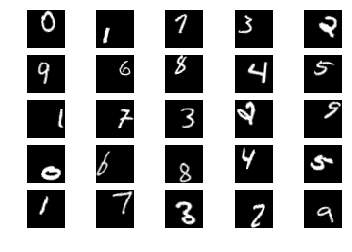

In [1]:
%matplotlib inline
from matplotlib import pyplot

from lib import load_batch
b = load_batch(1)

for row in range(5):
    for col in range(5):
        num = row * 5 + col
        pyplot.subplot(5, 5, num + 1)
        pyplot.axis('off')
        pyplot.imshow(b.image[num], cmap='gray')

Preprocessing
---

The images are cropped and put centraly inside a (34, 34) square.

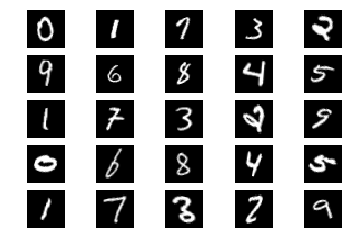

In [2]:
%matplotlib inline
from matplotlib import pyplot

from lib import load_batch, center
b = load_batch(1)

for row in range(5):
    for col in range(5):
        num = row * 5 + col
        pyplot.subplot(5, 5, num + 1)
        pyplot.axis('off')
        pyplot.imshow(center(b.image[num]), cmap='gray')

Model architecture
---

In [3]:
%matplotlib inline
from keras.models import load_model
from keras.utils.visualize_util import plot
model = load_model("my_model.h5")
plot(model)

![title](model.png)

Training and prediction
---

The following steps assume that test.csv and folder training_and_validation_batches with mat files are inside folder data.

**Warning!** The following steps take many hours on a decent hardware and override saved model weights, training history and answers.

In [ ]:
!python convnet_centered_deeper.py
!python train.py 1 33 40 center 

In [ ]:
!python make_test_npy.py
!python preprocess_test.py
!python answer.py

Training diagrams
---

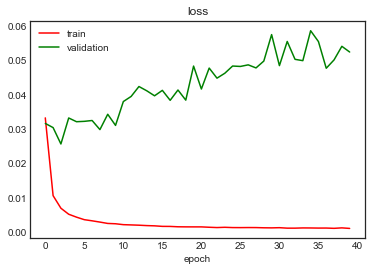

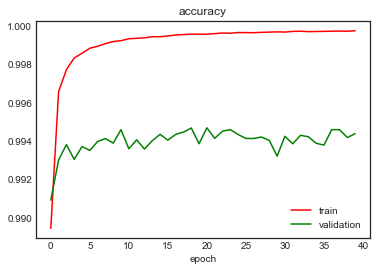

In [4]:
%matplotlib inline


import json
import numpy
from matplotlib import pyplot as plt
with open("my_hist.json") as f:
    hist = json.load(f)
plt.style.use('seaborn-white')
    
axis = numpy.arange(0, len(hist['val_categorical_accuracy']), 1)

plt.figure(1)
plt.title("loss")
plt.plot(axis, hist['loss'], 'r', label='train')
plt.plot(axis, hist['val_loss'], 'g', label='validation')
plt.xlabel("epoch")
plt.legend()


plt.figure(2)
plt.title("accuracy")
plt.plot(axis, hist['categorical_accuracy'], 'r', label='train')
plt.plot(axis, hist['val_categorical_accuracy'], 'g', label='validation')
plt.xlabel("epoch")
plt.legend()

In [5]:
with open("my_hist.json") as f:
    hist = json.load(f)


print("Final validation loss:", hist["val_loss"][-1])
print("Final validation accuracy", hist["val_categorical_accuracy"][-1])

Final validation loss: 0.05241838545081129
Final validation accuracy 0.994390625


Visualizing layers
---

The images below depcit the output at selected filters.

4 pairs of images were selected (two zeros, two ones, two twos and two threes). Additional 4 "partial" models were created. Each of them consists of some number of initial layers of the full model, last of them being activation layer.

The script predicts the output of the selected images on the "partial" models and shows the output of first 4 channels (more of them would be too verbose).

Some similarities in the output (especially in the last layer) should be visible for the same digits. In fact, for digit 3, the last two depicted channels are very similar (single dot at pixel in row 5 column 4 in the pre-last channel and 2x2 activated area in the last channel).

In [1]:
digits = [[0, 15], [1, 2], [4, 23], [3, 12]]
layers = [6, 12, 18]

In [2]:
from keras.models import load_model
model = load_model("my_model.h5")

Using TensorFlow backend.


In [3]:
from keras.models import Sequential
def reconstruct_model(last_layer):
    new_model = Sequential()
    for l in model.flattened_layers[:last_layer + 1]:
        new_model.add(l)
    new_model.compile(loss='categorical_crossentropy', optimizer='sgd')
    return new_model

partial_models = [reconstruct_model(l) for l in layers]

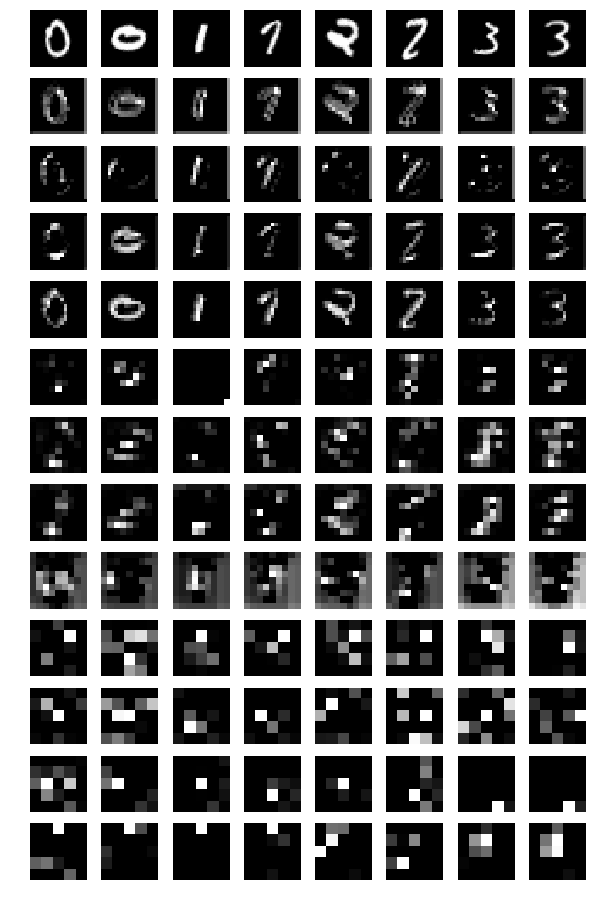

In [5]:
%matplotlib inline
from matplotlib import pyplot
pyplot.figure(figsize=(10, 16))

from lib import load_batch, center, imshow
b = load_batch(1)

from itertools import chain
width = len(list(chain(*digits)))
height = len(layers) * 4 + 1
subplot_num = 1
for col_num, image_num in enumerate(chain(*digits)):
    pyplot.subplot(height, width, subplot_num)
    pyplot.axis('off')
    image = center(b.image[image_num])
    imshow(image)
    subplot_num += 1

for display_num, partial_model in enumerate(partial_models):
    for filter_num in range(4):
        for col_num, image_num in enumerate(chain(*digits)):
            orig_img = center(b.image[image_num])
            imgs = partial_model.predict(orig_img.reshape(1, 34, 34, 1))[0, :, :, :]
            pyplot.subplot(height, width, subplot_num)
            pyplot.axis('off')
            imshow(imgs[:, :, filter_num])
            subplot_num += 1

Why 34x34?
---

All images fit 34x34. Proof follows.

In [10]:
import numpy
from lib import getbbox, load_batch

def batch_height_width(num):
    b = load_batch(num)
    for image in b.image:
        bbox = getbbox(image)
        height, width = bbox[1] - bbox[0], bbox[3] - bbox[2]
        yield height, width

def get_batches_height_width():
    for batch_num in range(1, 33):
        b = numpy.array(list(batch_height_width(batch_num)))
        yield b
        
b = numpy.array(list(get_batches_height_width()))
b.max(axis=0).max(axis=0)

array([34, 32])

In [11]:
import pandas
from lib import getbbox
def get_test_sizes():
    for chunk in pandas.read_csv("data/test.csv", chunksize=1000):
        chunk = chunk.values
        for image in chunk:
            assert image.shape == (1601,)
            image = image[1:].reshape(40, 40)
            bbox = getbbox(image)
            height, width = bbox[1] - bbox[0], bbox[3] - bbox[2]
            yield height, width
a = numpy.array(list(get_test_sizes()))
print(a.max(axis=0))

[34 32]
